In [1]:
!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries installed!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries installed!


In [43]:
import numpy as np
import pandas as pd
import urllib

import requests
from pandas.io.json import json_normalize
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

print('Libraries imported!')

Libraries imported!


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
list_df = pd.read_html(url, header = 0)
df = list_df[0]

In [3]:
df = df[(df.Borough != 'Not assigned')]

In [4]:
df['Neighborhood'] = df['Neighborhood'].str.replace('/',',')

C:\Users\Titas Sarkar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [5]:
df.Neighborhood[df['Neighborhood']=='Not assigned'] = df.Borough[df['Neighborhood']=='Not assigned']

C:\Users\Titas Sarkar\Anaconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Titas Sarkar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
print(df.shape)
df.head(10)

(103, 3)


,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,"Malvern , Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill , Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
coord = pd.read_csv('https://cocl.us/Geospatial_data')

In [8]:
coord.rename(index=str, columns={"Postal Code": "Postal code"}, inplace = True)

In [10]:
new_df = df.join(coord.set_index('Postal code'), on='Postal code')
new_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [11]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Using Folium to create a Map of Toronto with Boroughs markers on top

In [13]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, long, post, borough, neigh in zip(new_df['Latitude'], new_df['Longitude'], new_df['Postal code'], new_df['Borough'], new_df['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [20]:
new_df[new_df.Borough.str.contains('Toronto',case=False)]['Borough'].unique()

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

Creating a dataframe which has boroughs with 'Toronto' in their names

In [21]:
toronto_boroughs = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
toronto_df = new_df[new_df['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(toronto_df.shape)
toronto_df.head()

(39, 5)


,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Using Folium to create a Map of Toronto with Boroughs having 'Toronto' in their names and markers on top

In [22]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post, borough, neigh in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Postal code'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [24]:
CLIENT_ID = 'SWWNHHEKWCPEHJKBPCWLGGN5BNKHHKU243TGGEY3MHO4ZK4H'
CLIENT_SECRET = '3BTXLQDL404MXO4C2YQEITYN4HC4BR0AD2X5KO5YCCXNPZSR'
VERSION = '20180604'

Get recommended places inside or near each 'Toronto' named Boroughs

In [27]:
radius=500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Postal code'], toronto_df['Borough'], toronto_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [32]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Postal code', 'Borough', 'Neighborhood', 'Borough Latitude', 'Borough Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
print(venues_df.shape)
venues_df.head()

(1609, 9)


,Postal code,Borough,Neighborhood,Borough Latitude,Borough Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['Postal code'] = venues_df['Postal code'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1609, 234)


,Postal code,Borough,Neighborhoods,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
toronto_venues_freq = toronto_onehot.groupby(['Postal code', 'Borough', 'Neighborhoods']).mean().reset_index()
toronto_venues_freq.head()

,Postal code,Borough,Neighborhoods,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
1,M4K,East Toronto,"The Danforth West , Riverdale",0.0,0.0,0.0,0.0,0.0,0.023256,0.0,...,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000,0.0,0.023256
2,M4L,East Toronto,"India Bazaar , The Beaches West",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
3,M4M,East Toronto,Studio District,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.025000
4,M4N,Central Toronto,Lawrence Park,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000


Getting 10 most occurance venue types in each area

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Postal code', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal code'] = toronto_venues_freq['Postal code']
neighborhoods_venues_sorted['Borough'] = toronto_venues_freq['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_venues_freq['Neighborhoods']

for ind in np.arange(toronto_venues_freq.shape[0]):
    row_categories = toronto_venues_freq.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
neighborhoods_venues_sorted

,Postal code,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,M5V,Downtown Toronto,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Harbor / Marina,Sculpture Garden,Airport Food Court,Airport Gate,Bar,Boat or Ferry,Boutique,Coffee Shop
31,M6H,West Toronto,"Dufferin , Dovercourt Village",Bakery,Pharmacy,Park,Gym / Fitness Center,Middle Eastern Restaurant,Music Venue,Recording Studio,Café,Brewery,Brazilian Restaurant
32,M6J,West Toronto,"Little Portugal , Trinity",Bar,Restaurant,Vietnamese Restaurant,Men's Store,Vegetarian / Vegan Restaurant,Café,Asian Restaurant,Yoga Studio,Beer Store,Record Shop
25,M5S,Downtown Toronto,"University of Toronto , Harbord",Café,Bakery,Restaurant,Japanese Restaurant,Bookstore,Italian Restaurant,Bar,French Restaurant,Sandwich Place,Pub
33,M6K,West Toronto,"Brockton , Parkdale Village , Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Bakery,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,Burrito Place
3,M4M,East Toronto,Studio District,Café,Coffee Shop,Bakery,Gastropub,American Restaurant,Brewery,Yoga Studio,Cheese Shop,Bookstore,Italian Restaurant
26,M5T,Downtown Toronto,"Kensington Market , Chinatown , Grange Park",Café,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Grocery Store,Gaming Cafe,Bar,Arts & Crafts Store,Bakery,Dessert Shop
14,M5B,Downtown Toronto,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Thai Restaurant,Fast Food Restaurant
6,M4R,Central Toronto,North Toronto West,Clothing Store,Coffee Shop,Yoga Studio,Chinese Restaurant,Fast Food Restaurant,Salon / Barbershop,Spa,Sporting Goods Shop,Restaurant,Rental Car Location
19,M5J,Downtown Toronto,"Harbourfront East , Union Station , Toronto Is...",Coffee Shop,Aquarium,Restaurant,Italian Restaurant,Café,Hotel,Brewery,Scenic Lookout,Sporting Goods Shop,Fried Chicken Joint


To find the best k for clustering

In [47]:
k_rng=range(1,10)
sse=[]
for k in k_rng:
    km=KMeans(n_clusters=k)
    km.fit(toronto_venues_freq_clustering)
    sse.append(km.inertia_)

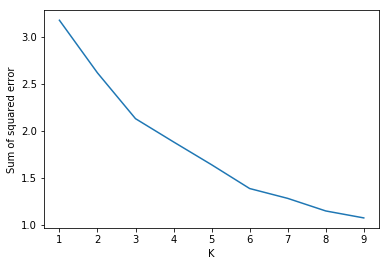

In [48]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [49]:
kclusters = 3

toronto_venues_freq_clustering = toronto_venues_freq.drop(['Postal code', 'Borough', 'Neighborhoods'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_venues_freq_clustering)

toronto_clustered_df = toronto_df
toronto_clustered_df['Cluster'] = kmeans.labels_

toronto_clustered_df = toronto_clustered_df.join(neighborhoods_venues_sorted.drop(['Borough', 'Neighborhoods'], 1).set_index('Postal code'), on='Postal code')
toronto_clustered_df.sort_values(['Cluster'] + freqColumns, inplace=True)
toronto_clustered_df

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,M5V,Downtown Toronto,"CN Tower , King and Spadina , Railway Lands , ...",43.628947,-79.394420,0,Airport Service,Airport Lounge,Harbor / Marina,Sculpture Garden,Airport Food Court,Airport Gate,Bar,Boat or Ferry,Boutique,Coffee Shop
9,M6H,West Toronto,"Dufferin , Dovercourt Village",43.669005,-79.442259,0,Bakery,Pharmacy,Park,Gym / Fitness Center,Middle Eastern Restaurant,Music Venue,Recording Studio,Café,Brewery,Brazilian Restaurant
11,M6J,West Toronto,"Little Portugal , Trinity",43.647927,-79.419750,0,Bar,Restaurant,Vietnamese Restaurant,Men's Store,Vegetarian / Vegan Restaurant,Café,Asian Restaurant,Yoga Studio,Beer Store,Record Shop
27,M5S,Downtown Toronto,"University of Toronto , Harbord",43.662696,-79.400049,0,Café,Bakery,Restaurant,Japanese Restaurant,Bookstore,Italian Restaurant,Bar,French Restaurant,Sandwich Place,Pub
14,M6K,West Toronto,"Brockton , Parkdale Village , Exhibition Place",43.636847,-79.428191,0,Café,Breakfast Spot,Nightclub,Coffee Shop,Bakery,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,Burrito Place
17,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Gastropub,American Restaurant,Brewery,Yoga Studio,Cheese Shop,Bookstore,Italian Restaurant
30,M5T,Downtown Toronto,"Kensington Market , Chinatown , Grange Park",43.653206,-79.400049,0,Café,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Grocery Store,Gaming Cafe,Bar,Arts & Crafts Store,Bakery,Dessert Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Thai Restaurant,Fast Food Restaurant
23,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0,Clothing Store,Coffee Shop,Yoga Studio,Chinese Restaurant,Fast Food Restaurant,Salon / Barbershop,Spa,Sporting Goods Shop,Restaurant,Rental Car Location
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Hotel,Cocktail Bar,Gastropub,Italian Restaurant,American Restaurant,Gym,Restaurant,Farmers Market


Showing the best clusters on the map

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_clustered_df['Latitude'], toronto_clustered_df['Longitude'], toronto_clustered_df['Postal code'], toronto_clustered_df['Borough'], toronto_clustered_df['Neighborhood'], toronto_clustered_df['Cluster']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Upon observing the result, we can name the clusters as follow:

Cluster 0: Living area (with mostly park, trail, school; and some small businesses)

Cluster 1: Roselawn - Central Toronto (nothing here except a garden)

Cluster 2: Business area (with lots of business venues)